# **New York City Yellow Taxi Data**

###  Data Description
You can find the data description here: [Data Dictionary](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)

**Trip Records**



|Field Name       |description |
|:----------------|:-----------|
| VendorID | A code indicating the TPEP provider that provided the record. <br> 1= Creative Mobile Technologies, LLC; <br> 2= VeriFone Inc. |
| tpep_pickup_datetime | The date and time when the meter was engaged.  |
| tpep_dropoff_datetime | The date and time when the meter was disengaged.   |
| Passenger_count | The number of passengers in the vehicle. <br> This is a driver-entered value. |
| Trip_distance | The elapsed trip distance in miles reported by the taximeter. |
| PULocationID | TLC Taxi Zone in which the taximeter was engaged |
| DOLocationID | TLC Taxi Zone in which the taximeter was disengaged |
|RateCodeID |The final rate code in effect at the end of the trip.<br> 1 = Standard rate <br> 2 = JFK <br> 3 = Newark <br>4 = Nassau or Westchester <br>5 = Negotiated fare <br>6 = Group ride |
|Store_and_fwd_flag |This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server.  <br>Y= store and forward trip <br>N= not a store and forward trip |
|Payment_type| A numeric code signifying how the passenger paid for the trip. <br> 1 = Credit card <br>2 = Cash <br>3 = No charge <br>4 = Dispute <br>5 = Unknown <br>6 = Voided trip |
|Fare_amount| The time-and-distance fare calculated by the meter. <br>Extra Miscellaneous extras and surcharges.  Currently, this only includes the 0.50 and 1 USD rush hour and overnight charges. |
|MTA_tax |0.50 USD MTA tax that is automatically triggered based on the metered rate in use. |
|Improvement_surcharge | 0.30 USD improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015. |
|Tip_amount |Tip amount – This field is automatically populated for credit card tips. Cash tips are not included. |
| Tolls_amount | Total amount of all tolls paid in trip.  |
| total_amount | The total amount charged to passengers. Does not include cash tips. |
|Congestion_Surcharge |Total amount collected in trip for NYS congestion surcharge. |
| Airport_fee | 1.25 USD for pick up only at LaGuardia and John F. Kennedy Airports|

Although the amounts of extra charges and taxes applied are specified in the data dictionary, you will see that some cases have different values of these charges in the actual data.

**Taxi Zones**

Each of the trip records contains a field corresponding to the location of the pickup or drop-off of the trip, populated by numbers ranging from 1-263.

These numbers correspond to taxi zones, which may be downloaded as a table or map/shapefile and matched to the trip records using a join.

---

## Data Preparation

### Import Libraries

In [1]:
# Import warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import the libraries you will be using for analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
# Check versions
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("matplotlib version:", plt.matplotlib.__version__)
print("seaborn version:", sns.__version__)

numpy version: 2.4.1
pandas version: 3.0.0
matplotlib version: 3.10.8
seaborn version: 0.13.2


### Loading the dataset

In [4]:
# loading one file
try:
    sam = pd.read_parquet('/kaggle/input/nyc-taxi-data-updrad/2023-1.parquet')
except FileNotFoundError:
    sam = pd.read_parquet("E:/Datasets/Datasets and Dictionary-NYC/trip_records/2023-2.parquet")

sam.info()

<class 'pandas.DataFrame'>
Index: 3374086 entries, 0 to 3403765
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int32         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     str           
 7   PULocationID           int32         
 8   DOLocationID           int32         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  Airport_fee            float64       


#### Sampling the Data

---

In [5]:

import os

os.chdir("E:/Datasets/Datasets and Dictionary-NYC/trip_records")

file_list = os.listdir()
df = pd.DataFrame()
for file_name in file_list:
    try:
        print(file_name)
        file_path = os.path.join(os.getcwd(), file_name)
        mon = pd.read_parquet(file_name)
        mon['tpep_pickup_datetime'] = pd.to_datetime(mon['tpep_pickup_datetime'])
        mon['date'] = mon['tpep_pickup_datetime'].dt.date
        mon['time'] = mon['tpep_pickup_datetime'].dt.hour
        dates = set(mon['date'].to_list())
        sampled_data = pd.DataFrame()
        for d in  dates:
            for h in range(0, 24):
                hour_df = mon[(mon['date'] == d) & (mon['time'] == h)]
                if not hour_df.empty:
                    sample = hour_df.sample(frac=0.05, random_state=42)
                    sampled_data = pd.concat([sampled_data, sample])
        df = pd.concat([df, sampled_data])

    except Exception as e:
        print(f"Error reading file {file_name}: {e}")
df

2023-1.parquet
2023-10.parquet
2023-11.parquet
2023-12.parquet
2023-2.parquet
2023-3.parquet
2023-4.parquet
2023-5.parquet
2023-6.parquet
2023-7.parquet
2023-8.parquet
2023-9.parquet


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,date,time,Airport_fee
2400187,1,2023-01-26 00:32:49,2023-01-26 00:56:44,1.0,10.10,1.0,N,132,225,2,...,0.5,0.00,0.00,1.0,42.45,0.0,1.25,2023-01-26,0,NaN
2400170,2,2023-01-26 00:15:37,2023-01-26 00:37:16,1.0,9.69,1.0,N,231,145,1,...,0.5,5.00,0.00,1.0,49.40,2.5,0.00,2023-01-26,0,NaN
2399393,2,2023-01-26 00:22:26,2023-01-26 00:28:41,1.0,0.63,1.0,N,114,113,1,...,0.5,2.44,0.00,1.0,14.64,2.5,0.00,2023-01-26,0,NaN
2398734,2,2023-01-26 00:32:31,2023-01-26 00:37:16,1.0,0.86,1.0,N,170,90,2,...,0.5,0.00,0.00,1.0,11.50,2.5,0.00,2023-01-26,0,NaN
2398879,1,2023-01-26 00:56:57,2023-01-26 01:04:53,1.0,1.60,1.0,N,211,261,1,...,0.5,3.14,0.00,1.0,18.84,2.5,0.00,2023-01-26,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1538917,2,2023-09-15 23:38:02,2023-09-15 23:41:21,2.0,0.35,1.0,N,239,142,2,...,0.5,0.00,0.00,1.0,10.10,2.5,NaN,2023-09-15,23,0.0
1537227,2,2023-09-15 23:39:51,2023-09-15 23:45:55,1.0,0.66,1.0,N,144,114,1,...,0.5,2.44,0.00,1.0,14.64,2.5,NaN,2023-09-15,23,0.0
1539117,2,2023-09-15 23:09:01,2023-09-15 23:32:22,1.0,3.25,1.0,N,164,151,2,...,0.5,0.00,0.00,1.0,28.30,2.5,NaN,2023-09-15,23,0.0
1540839,2,2023-09-15 23:12:21,2023-09-15 23:32:14,1.0,7.08,1.0,N,142,243,1,...,0.5,7.20,0.00,1.0,43.20,2.5,NaN,2023-09-15,23,0.0


In [6]:
# Store the df in csv/parquet
# df.to_parquet('')
df.to_parquet("nyc_taxi_sampled_final.parquet", index=False)

## Data Cleaning

In [7]:
# Load the new
df = pd.read_parquet("E:/Datasets/Datasets and Dictionary-NYC/trip_records/nyc_taxi_sampled_final.parquet")

In [8]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,date,time,Airport_fee
0,1,2023-01-26 00:32:49,2023-01-26 00:56:44,1.0,10.10,1.0,N,132,225,2,...,0.5,0.00,0.0,1.0,42.45,0.0,1.25,2023-01-26,0,NaN
1,2,2023-01-26 00:15:37,2023-01-26 00:37:16,1.0,9.69,1.0,N,231,145,1,...,0.5,5.00,0.0,1.0,49.40,2.5,0.00,2023-01-26,0,NaN
2,2,2023-01-26 00:22:26,2023-01-26 00:28:41,1.0,0.63,1.0,N,114,113,1,...,0.5,2.44,0.0,1.0,14.64,2.5,0.00,2023-01-26,0,NaN
3,2,2023-01-26 00:32:31,2023-01-26 00:37:16,1.0,0.86,1.0,N,170,90,2,...,0.5,0.00,0.0,1.0,11.50,2.5,0.00,2023-01-26,0,NaN
4,1,2023-01-26 00:56:57,2023-01-26 01:04:53,1.0,1.60,1.0,N,211,261,1,...,0.5,3.14,0.0,1.0,18.84,2.5,0.00,2023-01-26,0,NaN


In [9]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 1896400 entries, 0 to 1896399
Data columns (total 22 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     str           
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee            float64   

#### Fixing Columns

In [10]:
# Fixing the index and drop any columns that are not needed
df = df.reset_index(drop=True)
df = df.drop(columns=['date', 'time'])
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 1896400 entries, 0 to 1896399
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     str           
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee            float64   

In [11]:
# Combining the two airport fee columns
df['airport_fee'] = df['airport_fee'].combine_first(df['Airport_fee'])
df = df.drop(columns=['Airport_fee'])
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2023-01-26 00:32:49,2023-01-26 00:56:44,1.0,10.10,1.0,N,132,225,2,38.7,2.25,0.5,0.00,0.0,1.0,42.45,0.0,1.25
1,2,2023-01-26 00:15:37,2023-01-26 00:37:16,1.0,9.69,1.0,N,231,145,1,39.4,1.00,0.5,5.00,0.0,1.0,49.40,2.5,0.00
2,2,2023-01-26 00:22:26,2023-01-26 00:28:41,1.0,0.63,1.0,N,114,113,1,7.2,1.00,0.5,2.44,0.0,1.0,14.64,2.5,0.00
3,2,2023-01-26 00:32:31,2023-01-26 00:37:16,1.0,0.86,1.0,N,170,90,2,6.5,1.00,0.5,0.00,0.0,1.0,11.50,2.5,0.00
4,1,2023-01-26 00:56:57,2023-01-26 01:04:53,1.0,1.60,1.0,N,211,261,1,10.7,3.50,0.5,3.14,0.0,1.0,18.84,2.5,0.00


**2.1.3**
Fix columns with negative (monetary) values

In [12]:
# checking where values of fare amount are negative
(df['fare_amount'] < 0).sum()

np.int64(0)

In [13]:
# Analysing RatecodeID for the negative fare amounts
df.loc[df['RatecodeID'] == 99.0, 'RatecodeID'] = 1
df['RatecodeID'].value_counts()

RatecodeID
1.0    1739731
2.0      71670
5.0      10275
3.0       6124
4.0       3723
6.0          3
Name: count, dtype: int64

In [14]:
# Finding which columns have negative values
col = ['passenger_count', 'trip_distance','store_and_fwd_flag', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee']
y = {}
for i in col:
    if pd.api.types.is_any_real_numeric_dtype(df[i]):
        y[i] = (df[i] < 0).sum()
y

{'passenger_count': np.int64(0),
 'trip_distance': np.int64(0),
 'fare_amount': np.int64(0),
 'extra': np.int64(3),
 'mta_tax': np.int64(73),
 'tip_amount': np.int64(0),
 'tolls_amount': np.int64(0),
 'improvement_surcharge': np.int64(78),
 'total_amount': np.int64(78),
 'congestion_surcharge': np.int64(56),
 'airport_fee': np.int64(15)}

In [15]:
# Negative values
x = fee_cols = [
    'extra',
    'mta_tax',
    'improvement_surcharge',
    'congestion_surcharge',
    'airport_fee'
]
for i in x:
    df.loc[df[i] < 0, i] = 0

In [16]:
### Total_amount
df['total_amount'] = (
    df['fare_amount']
    + df['extra']
    + df['mta_tax']
    + df['tip_amount']
    + df['tolls_amount']
    + df['improvement_surcharge']
    + df['congestion_surcharge']
    + df['airport_fee']
)

In [17]:
y = {}
for i in col:
    if pd.api.types.is_any_real_numeric_dtype(df[i]):
        y[i] = (df[i] < 0).sum()
y

{'passenger_count': np.int64(0),
 'trip_distance': np.int64(0),
 'fare_amount': np.int64(0),
 'extra': np.int64(0),
 'mta_tax': np.int64(0),
 'tip_amount': np.int64(0),
 'tolls_amount': np.int64(0),
 'improvement_surcharge': np.int64(0),
 'total_amount': np.int64(0),
 'congestion_surcharge': np.int64(0),
 'airport_fee': np.int64(0)}

### Handling Missing Values

In [18]:
# Finding the proportion of missing values in each column
df.isnull().sum()

VendorID                     0
tpep_pickup_datetime         0
tpep_dropoff_datetime        0
passenger_count          64874
trip_distance                0
RatecodeID               64874
store_and_fwd_flag       64874
PULocationID                 0
DOLocationID                 0
payment_type                 0
fare_amount                  0
extra                        0
mta_tax                      0
tip_amount                   0
tolls_amount                 0
improvement_surcharge        0
total_amount             64874
congestion_surcharge     64874
airport_fee              64874
dtype: int64

In [19]:
# handling NaN values in 'passenger_count'
mode_value = df['passenger_count'].mode()[0]
df['passenger_count'] = df['passenger_count'].fillna(mode_value)
df['passenger_count'].isnull().sum()
df.loc[df['passenger_count'] == 0, 'passenger_count'] = mode_value
df['passenger_count'].value_counts()

passenger_count
1.0    1471779
2.0     277298
3.0      69034
4.0      38537
5.0      23871
6.0      15860
8.0         11
7.0          5
9.0          5
Name: count, dtype: int64

In [20]:
# Fixing missing values in 'RatecodeID'
df.loc[df['RatecodeID'] == 99, 'RatecodeID'] = 1
df['RatecodeID'].value_counts().sort_index()
df['RatecodeID'] = df['RatecodeID'].fillna(1.0)
df['RatecodeID'].isnull().sum()

np.int64(0)

In [21]:
# Handleing null values in congestion_surcharge
df['congestion_surcharge'] = df['congestion_surcharge'].fillna(0)

### handling missing values in other columns.

In [22]:
# Handle any remaining missing values
df['store_and_fwd_flag'].value_counts()
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].fillna('N')
df['airport_fee'] = df['airport_fee'].fillna(0.00)
df['total_amount'] = df['total_amount'].fillna(0)

In [23]:
df['total_amount'] = (
    df['fare_amount']
    + df['extra']
    + df['mta_tax']
    + df['tip_amount']
    + df['tolls_amount']
    + df['improvement_surcharge']
    + df['congestion_surcharge']
    + df['airport_fee']
)

In [24]:
df.isnull().sum()

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
congestion_surcharge     0
airport_fee              0
dtype: int64

### Handling Outliers

In [25]:
df.describe()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
count,1.896400e+06,1896400,1896400,1.896400e+06,1.896400e+06,1.896400e+06,1.896400e+06,1.896400e+06,1.896400e+06,1.896400e+06,1.896400e+06,1.896400e+06,1.896400e+06,1.896400e+06,1.896400e+06,1.896400e+06,1.896400e+06,1.896400e+06
mean,1.733026e+00,2023-07-02 19:59:52.930795,2023-07-02 20:17:18.919563,1.372236e+00,3.858293e+00,1.071821e+00,1.652814e+02,1.640515e+02,1.163817e+00,1.991935e+01,1.588020e+00,4.952989e-01,3.547011e+00,5.965338e-01,9.990118e-01,2.951191e+01,2.228660e+00,1.380220e-01
min,1.000000e+00,2022-12-31 23:51:30,2022-12-31 23:56:06,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,2023-04-02 16:10:08.750000,2023-04-02 16:27:43.500000,1.000000e+00,1.050000e+00,1.000000e+00,1.320000e+02,1.140000e+02,1.000000e+00,9.300000e+00,0.000000e+00,5.000000e-01,1.000000e+00,0.000000e+00,1.000000e+00,1.654000e+01,2.500000e+00,0.000000e+00
50%,2.000000e+00,2023-06-27 15:44:22.500000,2023-06-27 16:01:15,1.000000e+00,1.790000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,1.350000e+01,1.000000e+00,5.000000e-01,2.850000e+00,0.000000e+00,1.000000e+00,2.180000e+01,2.500000e+00,0.000000e+00
75%,2.000000e+00,2023-10-06 19:37:45,2023-10-06 19:53:39,1.000000e+00,3.400000e+00,1.000000e+00,2.340000e+02,2.340000e+02,1.000000e+00,2.190000e+01,2.500000e+00,5.000000e-01,4.420000e+00,0.000000e+00,1.000000e+00,3.144000e+01,2.500000e+00,0.000000e+00
max,6.000000e+00,2023-12-31 23:57:51,2024-01-01 20:50:55,9.000000e+00,1.263605e+05,6.000000e+00,2.650000e+02,2.650000e+02,4.000000e+00,1.431635e+05,2.080000e+01,4.000000e+00,2.230800e+02,1.430000e+02,1.000000e+00,1.431700e+05,2.500000e+00,1.750000e+00
std,4.476401e-01,NaN,NaN,8.644038e-01,1.294085e+02,3.872343e-01,6.400038e+01,6.980207e+01,5.081384e-01,1.055371e+02,1.829197e+00,4.855675e-02,4.054882e+00,2.187878e+00,2.907216e-02,1.064179e+02,7.776405e-01,4.575627e-01


In [26]:
len(df.columns)

19

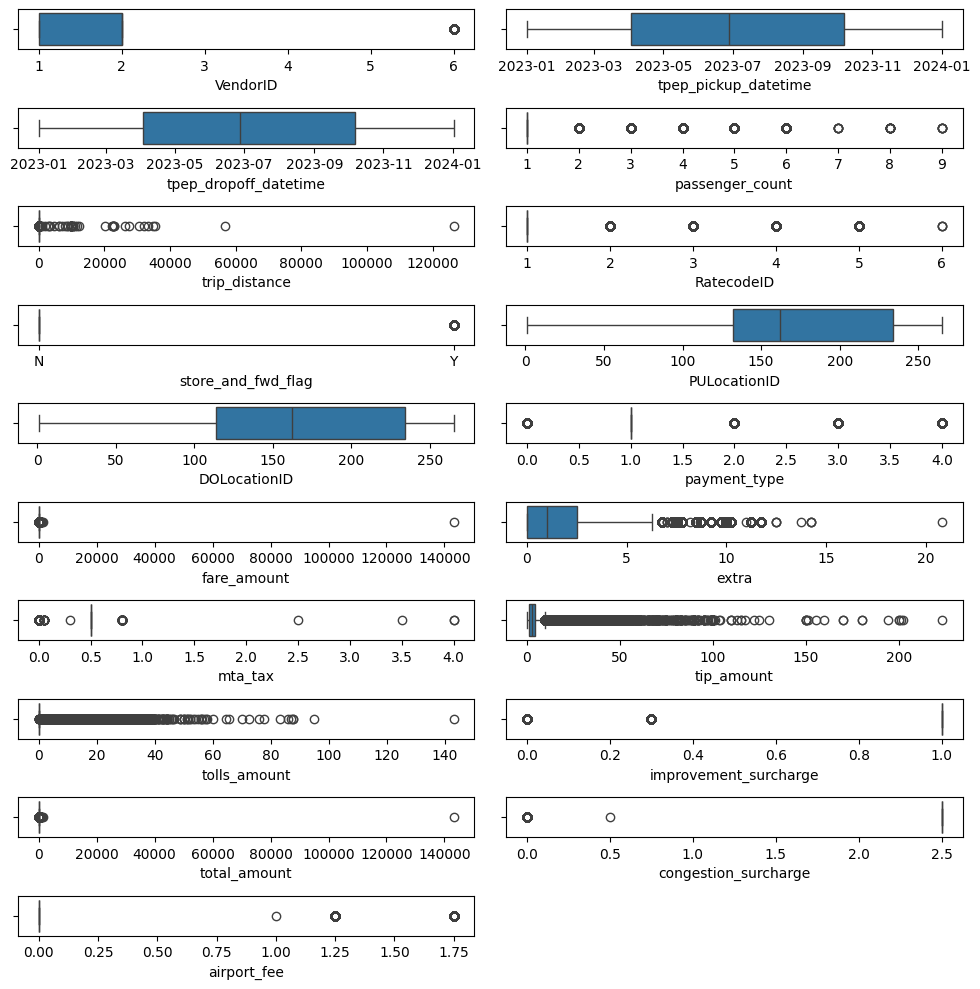

In [27]:
n = 1
plt.figure(figsize=(10, 10))
for i in df.columns:
    if n <= len(df.columns):
        ax = plt.subplot(10, 2, n)
        sns.boxplot(x= df[i])
    n += 1
plt.tight_layout()

In [28]:
# remove passenger_count > 6
df['passenger_count'].describe()
df = df.drop(df[df['passenger_count'] > 6].index)
df['passenger_count'].describe()

count    1.896379e+06
mean     1.372162e+00
std      8.641241e-01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      6.000000e+00
Name: passenger_count, dtype: float64

In [29]:
# Outlier handling
bad_entry = df[(df['fare_amount'] > 300) & (df['trip_distance'] < 0.1)]
bad_index = bad_entry.index
df = df.drop(bad_index)
df = df.drop(df[df['trip_distance'] >= 250].index)
df = df.drop(df[(df['trip_distance'] == 0) & (df['DOLocationID'] != df['PULocationID']) & (df['trip_distance'] == 0)].index)
df = df.drop(df[df['payment_type'] <= 0].index)
df =df.drop(df[df['fare_amount'] <= 0].index)
df = df.drop(df[df['fare_amount'] >= 500].index)
df = df.drop_duplicates()

In [30]:
# Standardising columns.
df['total_amount'] = (df['fare_amount'] + df['extra'] + df['mta_tax'] + df['tip_amount']
                      + df['tolls_amount'] + df['improvement_surcharge'] + df['congestion_surcharge'] + df['airport_fee'])
df.isnull().sum()

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
congestion_surcharge     0
airport_fee              0
dtype: int64

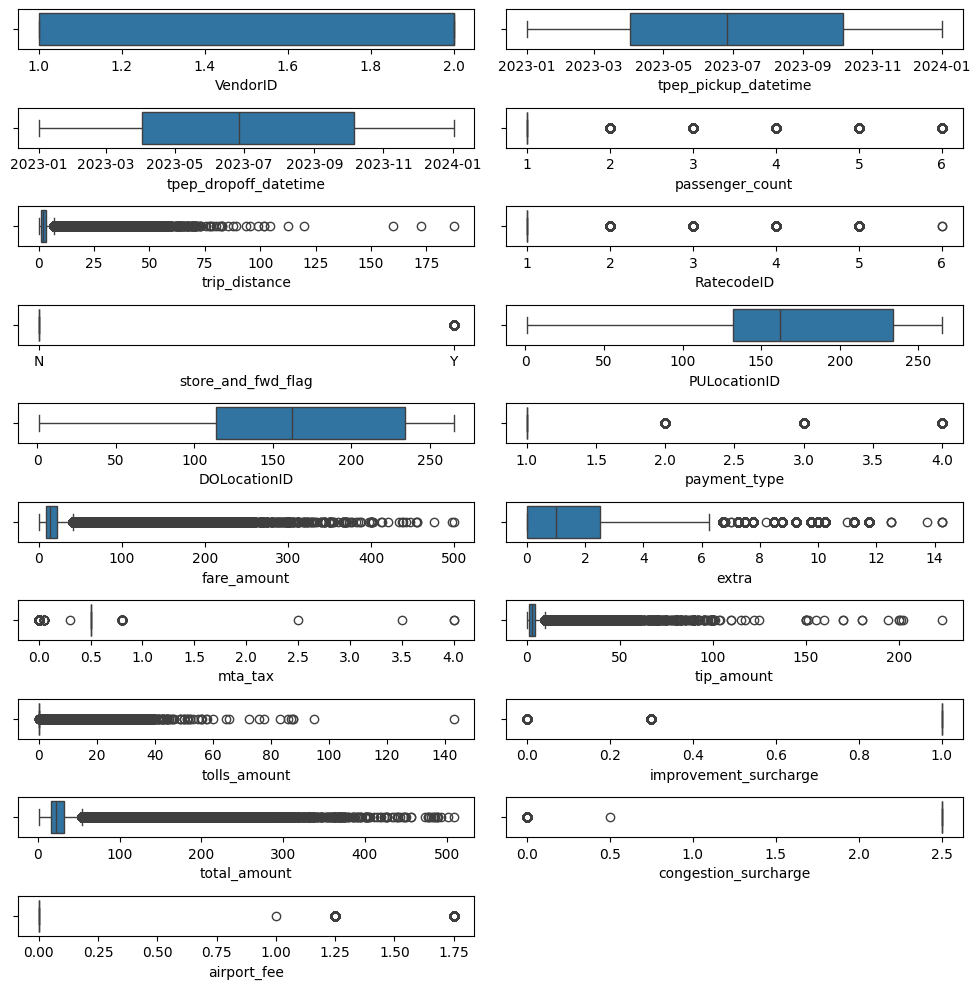

In [31]:
n = 1
plt.figure(figsize=(10, 10))
for i in df.columns:
    if n <= len(df.columns):
        ax = plt.subplot(10, 2, n)
        sns.boxplot(x= df[i])
    n += 1
plt.tight_layout()

## **3** Exploratory Data Analysis

In [32]:
df.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
VendorID,1823140.0,1.737572,1.0,1.0,2.0,2.0,2.0,0.439954
tpep_pickup_datetime,1823140,2023-07-01 21:54:04.440026,2022-12-31 23:51:30,2023-04-01 20:57:12,2023-06-26 08:54:03.500000,2023-10-05 19:45:50,2023-12-31 23:57:51,NaN
tpep_dropoff_datetime,1823140,2023-07-01 22:11:25.022653,2022-12-31 23:56:06,2023-04-01 21:12:21.250000,2023-06-26 09:14:11,2023-10-05 20:04:04,2024-01-01 20:50:55,NaN
passenger_count,1823140.0,1.386069,1.0,1.0,1.0,1.0,6.0,0.877134
trip_distance,1823140.0,3.458412,0.0,1.06,1.8,3.39,187.35,4.534209
RatecodeID,1823140.0,1.072768,1.0,1.0,1.0,1.0,6.0,0.385969
PULocationID,1823140.0,165.51879,1.0,132.0,162.0,234.0,265.0,63.639427
DOLocationID,1823140.0,164.332852,1.0,114.0,162.0,234.0,265.0,69.710243
payment_type,1823140.0,1.204202,1.0,1.0,1.0,1.0,4.0,0.464881
fare_amount,1823140.0,19.714214,0.01,9.3,13.5,21.9,499.0,18.126262


In [33]:
cols = df.columns.tolist()
cols

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'airport_fee']

#### **3.1** General EDA: Finding Patterns and Trends

##### Temporal Analysis

Distribution of taxi pickups by hours, days of the week, and months.

  week_day_name   count
0        Monday  227774
1        Sunday  229350
2       Tuesday  264625
3      Saturday  264847
4        Friday  270297
5     Wednesday  280266
6      Thursday  285981


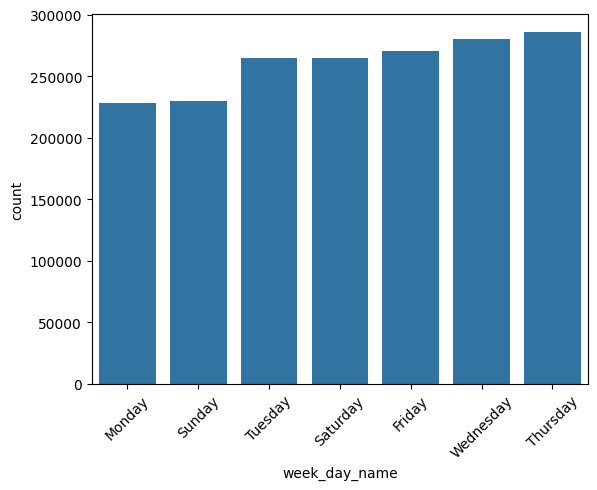

In [34]:
# Daily trends in taxi pickups (days of the week)

df['week_day_name'] = pd.to_datetime(df['tpep_pickup_datetime']).dt.day_name()
x = df['week_day_name'].value_counts().sort_values()
x = x.reset_index()
print(x)
sns.barplot(data= x, x = 'week_day_name', y= 'count')
plt.xticks(rotation=45)
plt.show()

    pickup_hour   count
0             4    9327
1             5    9885
2             3   14635
3             2   22448
4             6   24280
5             1   34152
6             7   48680
7             0   50978
8             8   67924
9            23   74565
10            9   77894
11           10   85239
12           11   92559
13           22   94862
14           12  100464
15           21  102794
16           20  103082
17           13  103566
18           14  111051
19           15  113749
20           16  113783
21           19  115488
22           17  123030
23           18  128705


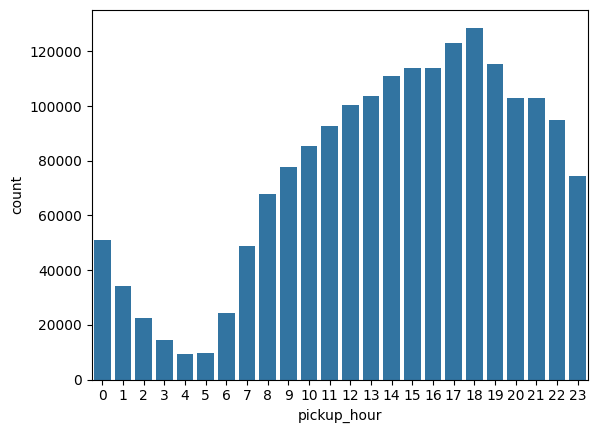

In [35]:
# Find and show the hourly trends in taxi pickups
df['pickup_hour'] = pd.to_datetime(df['tpep_pickup_datetime']).dt.hour
x = df['pickup_hour'].value_counts().sort_values()
x = x.reset_index()
print(x)
sns.barplot(data=x, x = 'pickup_hour', y = 'count')
plt.show()

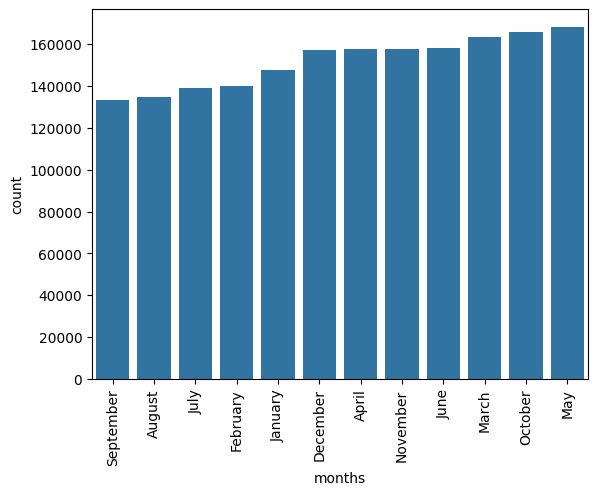

In [36]:
# Show the monthly trends in pickups
df['months'] = pd.to_datetime(df['tpep_pickup_datetime']).dt.month_name()
x = df['months'].value_counts().sort_values()
x = x.reset_index()
plt.figure()
sns.barplot(data= x, x = 'months', y = 'count')
plt.xticks(rotation= 90)
plt.show()

##### Financial Analysis

In [37]:
y = ['fare_amount', 'tip_amount', 'total_amount', 'trip_distance']
for i in y:
    print(f'{i}')
    print(f'{df[i].describe()}\n')

fare_amount
count    1.823140e+06
mean     1.971421e+01
std      1.812626e+01
min      1.000000e-02
25%      9.300000e+00
50%      1.350000e+01
75%      2.190000e+01
max      4.990000e+02
Name: fare_amount, dtype: float64

tip_amount
count    1.823140e+06
mean     3.580993e+00
std      4.062647e+00
min      0.000000e+00
25%      1.000000e+00
50%      2.860000e+00
75%      4.450000e+00
max      2.230800e+02
Name: tip_amount, dtype: float64

total_amount
count    1.823140e+06
mean     2.948074e+01
std      2.277123e+01
min      1.010000e+00
25%      1.656000e+01
50%      2.175000e+01
75%      3.140000e+01
max      5.085000e+02
Name: total_amount, dtype: float64

trip_distance
count    1.823140e+06
mean     3.458412e+00
std      4.534209e+00
min      0.000000e+00
25%      1.060000e+00
50%      1.800000e+00
75%      3.390000e+00
max      1.873500e+02
Name: trip_distance, dtype: float64



Copy DataFrame leaving out the zero values.

In [38]:
df_clean = df[(df['trip_distance'] > 0) & (df['passenger_count'] > 0) & (df['fare_amount'] > 0)]
df = df[(df['fare_amount'] != 0) & (df['total_amount'] != 0)]
df[['fare_amount', 'tip_amount', 'total_amount', 'trip_distance']].min()

fare_amount      0.01
tip_amount       0.00
total_amount     1.01
trip_distance    0.00
dtype: float64

Analysis of the monthly revenue (`total_amount`) trend

total amount sum in ascending order
       months  total_amount
0    February    3902523.11
1      August    4009991.98
2   September    4086621.11
3        July    4117314.98
4     January    4130675.29
5       April    4625655.07
6    December    4675805.73
7    November    4688603.21
8       March    4708021.75
9        June    4735654.84
10        May    5031954.75
11    October    5034703.30


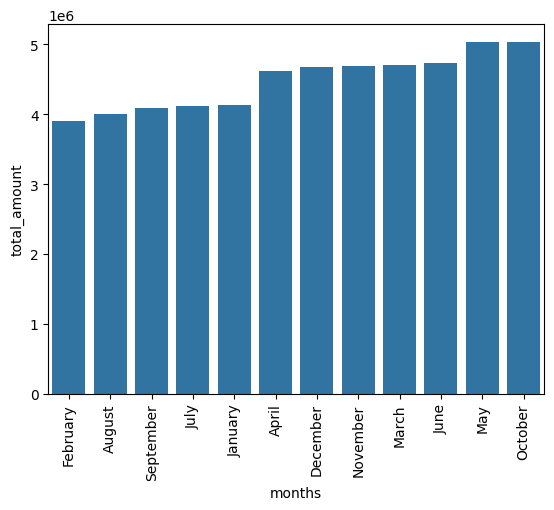

In [39]:
# Group data by month and analyse monthly revenue
total_amount = df.groupby('months')['total_amount'].sum().sort_values().reset_index()
print('total amount sum in ascending order')
print(total_amount)

plt.figure()
sns.barplot(data= total_amount, x = 'months', y= 'total_amount')
plt.xticks(rotation=90)
plt.show()


Proportion of each quarter of the year in the revenue

monthly quarter sales in acesending order
   month_quarter  total_amount
0              1   12741220.15
1              2   14393264.66
2              3   12213928.07
3              4   14399112.24


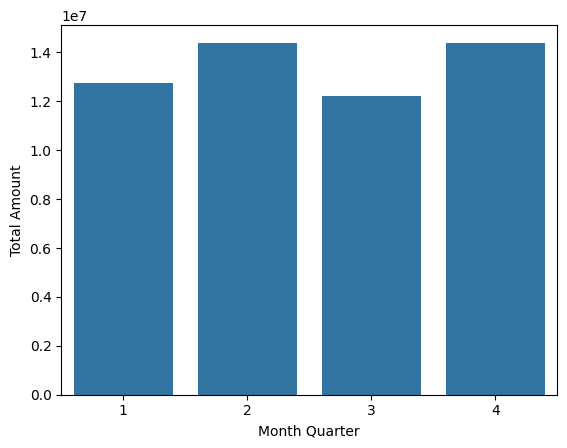

In [40]:
# Calculating proportion of each quarter
df['month_quarter'] = pd.to_datetime(df['tpep_pickup_datetime']).dt.quarter
quarter_amount = df.groupby('month_quarter')['total_amount'].sum().reset_index()
print('monthly quarter sales in acesending order')
print(quarter_amount)

plt.figure()
sns.barplot(data=quarter_amount, x = 'month_quarter', y = 'total_amount')
plt.xlabel('Month Quarter')
plt.ylabel('Total Amount')
plt.show()

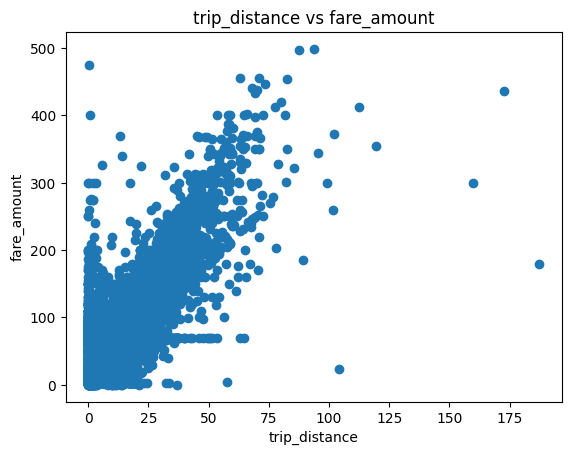

In [41]:
# Trip fare is affected by distance
trip_df = df.drop(df[df['trip_distance'] == 0].index)

plt.figure()
plt.scatter(trip_df['trip_distance'], trip_df['fare_amount'])
plt.xlabel('trip_distance')
plt.ylabel('fare_amount')
plt.title('trip_distance vs fare_amount')
plt.show()

In [42]:
# Relationship between fare and trip duration
df["trip_duration"] = pd.to_datetime(df['tpep_dropoff_datetime']) - pd.to_datetime(df['tpep_pickup_datetime'])
df['trip_duration'] = df['trip_duration'].dt.total_seconds() / 60
df = df[df['trip_duration'] > 0]
df = df[df['trip_duration']<= 2000 ]
df['trip_duration'].describe()

count    1.822979e+06
mean     1.732446e+01
std      4.031954e+01
min      1.666667e-02
25%      7.600000e+00
50%      1.253333e+01
75%      2.048333e+01
max      1.759517e+03
Name: trip_duration, dtype: float64

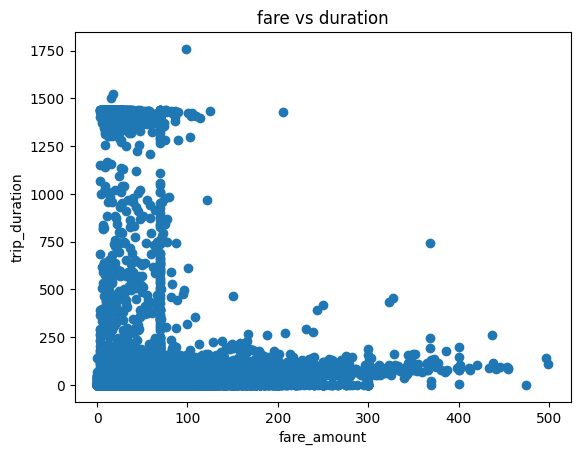

In [43]:
plt.figure()
plt.scatter(df['fare_amount'], df['trip_duration'])
plt.xlabel('fare_amount')
plt.ylabel('trip_duration')
plt.title('fare vs duration')
plt.show()

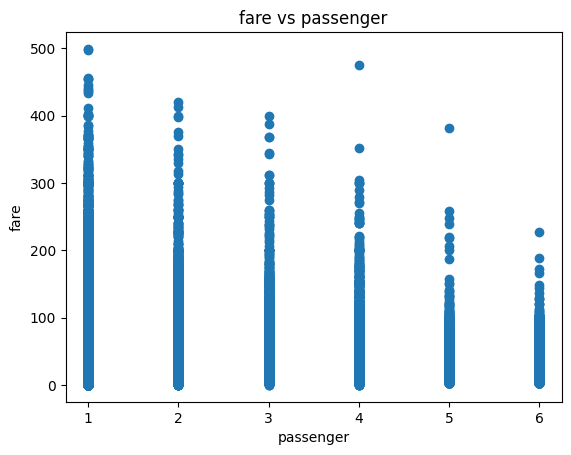

In [44]:
# Relationship between fare and number of passengers
plt.figure()
plt.scatter(df['passenger_count'], df['fare_amount'])
plt.ylabel('fare')
plt.xlabel('passenger')
plt.title('fare vs passenger')
plt.show()

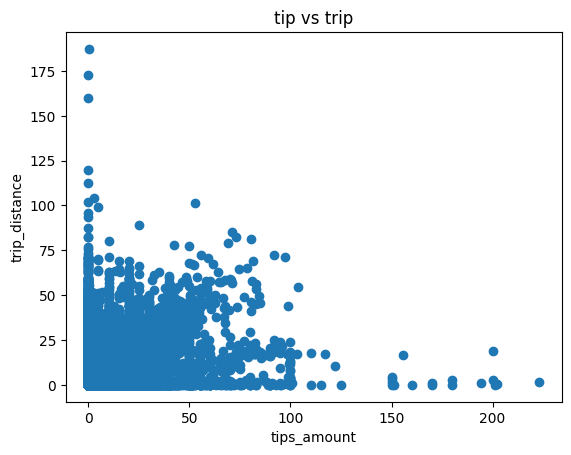

In [45]:
# Relationship between tip and trip distance
plt.figure()
plt.scatter(df['tip_amount'], df['trip_distance'])
plt.xlabel('tips_amount')
plt.ylabel('trip_distance')
plt.title('tip vs trip')
plt.show()

In [46]:
df['payment_type'].value_counts()

payment_type
1    1486221
2     314679
4      13389
3       8690
Name: count, dtype: int64

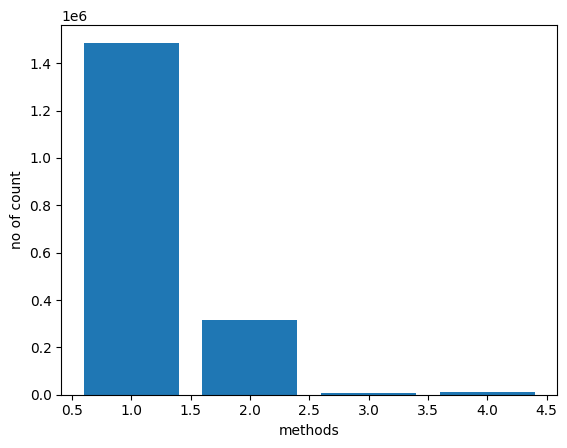

In [47]:
# Analyse the distribution of different payment types (payment_type).
values = df['payment_type'].value_counts()
plt.figure()
plt.bar(values.index, values.values)
plt.ylabel('no of count')
plt.xlabel('methods')
plt.show()

- 1= Credit card
- 2= Cash
- 3= No charge
- 4= Dispute



##### Geographical Analysis

In [48]:
!pip install geopandas


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [49]:
# read the .shp file using gpd
# Read the shapefile using geopandas

import geopandas as gpd

try:
    zones = gpd.read_file('/kaggle/input/nyc-taxi-data-updrad/taxi_zones.shp')
except Exception:
    zones = gpd.read_file("E:/Datasets/Datasets and Dictionary-NYC/taxi_zones/taxi_zones.shp")
zones.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.77 256767.698, 1026495.593 2..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.31 144283.336, 936046.565 144..."


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    263 non-null    int32   
 1   Shape_Leng  263 non-null    float64 
 2   Shape_Area  263 non-null    float64 
 3   zone        263 non-null    str     
 4   LocationID  263 non-null    int32   
 5   borough     263 non-null    str     
 6   geometry    263 non-null    geometry
dtypes: float64(2), geometry(1), int32(2), str(2)
memory usage: 18.5 KB
None


<Axes: >

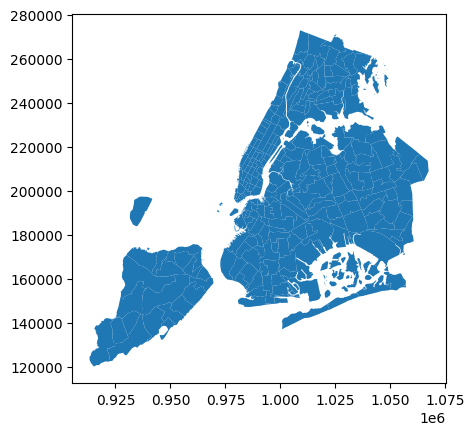

In [50]:
print(zones.info())
zones.plot()

In [51]:
# Merging zones and trip records using locationID and PULocationID
df_merged = df.merge(zones, left_on= 'PULocationID', right_on='LocationID', how='left') 
df_merged.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,months,month_quarter,trip_duration,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,2023-01-26 00:32:49,2023-01-26 00:56:44,1.0,10.10,1.0,N,132,225,2,...,January,1,23.916667,132.0,0.245479,0.002038,JFK Airport,132.0,Queens,"MULTIPOLYGON (((1032791.001 181085.006, 103283..."
1,2,2023-01-26 00:15:37,2023-01-26 00:37:16,1.0,9.69,1.0,N,231,145,1,...,January,1,21.650000,231.0,0.063420,0.000167,TriBeCa/Civic Center,231.0,Manhattan,"POLYGON ((981667.364 203305, 981854.109 203130..."
2,2,2023-01-26 00:22:26,2023-01-26 00:28:41,1.0,0.63,1.0,N,114,113,1,...,January,1,6.250000,114.0,0.031727,0.000047,Greenwich Village South,114.0,Manhattan,"POLYGON ((986306.712 203122.786, 986300.242 20..."
3,2,2023-01-26 00:32:31,2023-01-26 00:37:16,1.0,0.86,1.0,N,170,90,2,...,January,1,4.750000,170.0,0.045769,0.000074,Murray Hill,170.0,Manhattan,"POLYGON ((991999.299 210994.739, 991972.635 21..."
4,1,2023-01-26 00:56:57,2023-01-26 01:04:53,1.0,1.60,1.0,N,211,261,1,...,January,1,7.933333,211.0,0.025235,0.000040,SoHo,211.0,Manhattan,"POLYGON ((983827.65 201526.658, 983727.737 201..."


Grouping data by location IDs to find the total number of trips per location ID

    LocationID  No_of_trips
0        132.0        96468
1        237.0        86706
2        161.0        85684
3        236.0        77319
4        162.0        65450
5        138.0        64054
6        186.0        63228
7        230.0        61093
8        142.0        60683
9        170.0        54296
10       163.0        53596
11       239.0        50197
12       234.0        49217
13        48.0        48631
14        68.0        47605
15       141.0        43325
16        79.0        42847
17       164.0        42583
18       249.0        40315
19       107.0        38319
20       140.0        35811
21       229.0        35118
22       238.0        34811
23       263.0        34780
24        43.0        30657
25       246.0        30519
26       100.0        30080
27        90.0        29504
28       113.0        25023
29       231.0        24258
30       114.0        24051
31       262.0        23556
32       233.0        22580
33       137.0        19577
34       143.0      

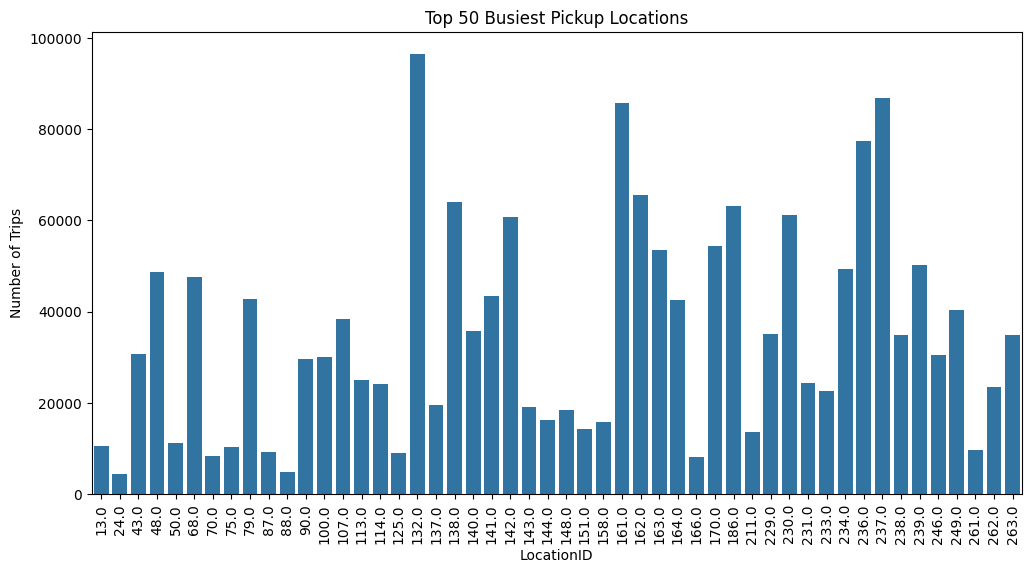

In [52]:
# Grouping data by location and calculate the number of trips
trip_count = df_merged.groupby('LocationID')['VendorID'].count().sort_values(ascending=False)
trip_count = trip_count.reset_index()
trip_count.columns = ['LocationID', 'No_of_trips']

# Top 20 busiest locations
top_50 = trip_count.head(50)
print(top_50)

# Bar Plot: Top 20 Busiest Zones
plt.figure(figsize=(12, 6))
sns.barplot(data=top_50, x='LocationID', y='No_of_trips')
plt.xticks(rotation=90)
plt.title("Top 50 Busiest Pickup Locations")
plt.xlabel("LocationID")
plt.ylabel("Number of Trips")
plt.show()


In [53]:
# Merging trip counts back to the zones GeoDataFrame
zones_trips = zones.merge(trip_count, on='LocationID', how='left')
zones_trips['No_of_trips'] = zones_trips['No_of_trips'].fillna(0)
zones_trips

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,No_of_trips
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19...",199.0
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343...",2.0
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.77 256767.698, 1026495.593 2...",34.0
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20...",1843.0
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.31 144283.336, 936046.565 144...",10.0
...,...,...,...,...,...,...,...,...
258,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx,"POLYGON ((1025414.782 270986.139, 1025138.624 ...",41.0
259,260,0.133514,0.000422,Woodside,260,Queens,"POLYGON ((1011466.966 216463.005, 1011545.889 ...",339.0
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,"POLYGON ((980555.204 196138.486, 980570.792 19...",9564.0
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,"MULTIPOLYGON (((999804.795 224498.527, 999824....",23556.0


Plot a color-coded map showing zone-wise trips

<Axes: >

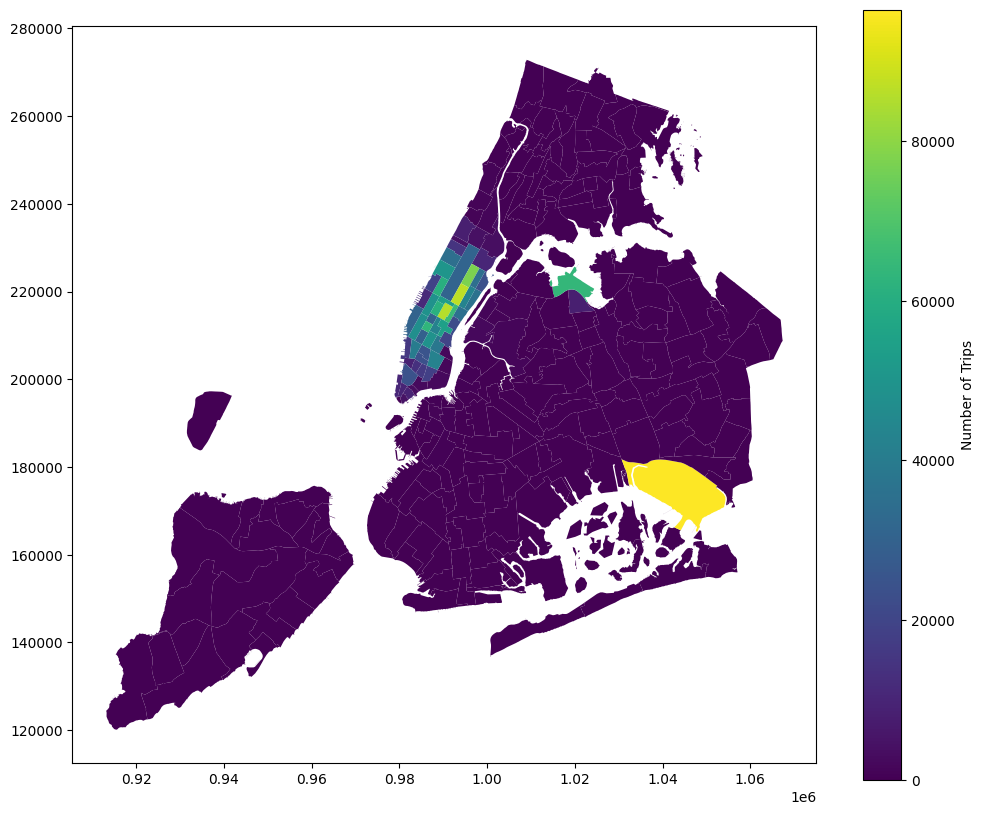

In [54]:
# Defining figure and axis
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
# Ploting the map and display it
zones_trips.plot(
    column='No_of_trips',
    ax=ax,
    legend=True,
    legend_kwds={
        'label': "Number of Trips",
        'orientation': "vertical"
    }
)

In [55]:
# Displaying the zones DF sorted by the number of trips?
zones_sorted = zones_trips.sort_values(by='No_of_trips', ascending=False)
zones_sorted.head(20)

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,No_of_trips
131,132,0.245479,0.002038,JFK Airport,132,Queens,"MULTIPOLYGON (((1032791.001 181085.006, 103283...",96468.0
236,237,0.042213,0.000096,Upper East Side South,237,Manhattan,"POLYGON ((993633.442 216961.016, 993507.232 21...",86706.0
160,161,0.035804,0.000072,Midtown Center,161,Manhattan,"POLYGON ((991081.026 214453.698, 990952.644 21...",85684.0
235,236,0.044252,0.000103,Upper East Side North,236,Manhattan,"POLYGON ((995940.048 221122.92, 995812.322 220...",77319.0
161,162,0.035270,0.000048,Midtown East,162,Manhattan,"POLYGON ((992224.354 214415.293, 992096.999 21...",65450.0
137,138,0.107467,0.000537,LaGuardia Airport,138,Queens,"MULTIPOLYGON (((1019904.219 225677.983, 102031...",64054.0
185,186,0.024696,0.000037,Penn Station/Madison Sq West,186,Manhattan,"POLYGON ((986752.603 210853.699, 986627.863 21...",63228.0
229,230,0.031028,0.000056,Times Sq/Theatre District,230,Manhattan,"POLYGON ((988786.877 214532.094, 988650.277 21...",61093.0
141,142,0.038176,0.000076,Lincoln Square East,142,Manhattan,"POLYGON ((989380.305 218980.247, 989359.803 21...",60683.0
169,170,0.045769,0.000074,Murray Hill,170,Manhattan,"POLYGON ((991999.299 210994.739, 991972.635 21...",54296.0


#### Detailed EDA: Insights and Strategies

##### Operational Efficiency

Analyzing variations by time of day and location to identify bottlenecks or inefficiencies in routes

Speed on a route *X* for hour *Y* = (*distance of the route X / average trip duration for hour Y*)

In [56]:
# Finding routes which have the slowest speeds at different times of the day
df_merged['speed'] = df_merged['trip_distance'] / (df_merged['trip_duration'] / 60)
df_merged['route'] = df_merged['PULocationID'].astype(str) + "-" + df_merged['DOLocationID'].astype(str)
trip_speed = df_merged.groupby(['pickup_hour', "route"])['speed'].mean()
trip_speed = trip_speed.reset_index()
trip_speed = trip_speed.sort_values(by=['pickup_hour', 'speed'], ascending=[True, True])
trip_speed = trip_speed.groupby('pickup_hour').first()
trips_per_hour = df.groupby('pickup_hour').size().reset_index(name='num_trips')
x_df = trips_per_hour.merge(trip_speed, on= 'pickup_hour', how='left')
x_df = x_df.sort_values('num_trips')
print(x_df)

    pickup_hour  num_trips    route  speed
4             4       9327      1-1    0.0
5             5       9885    11-11    0.0
3             3      14634    10-10    0.0
2             2      22448  116-116    0.0
6             6      24273    10-10    0.0
1             1      34113      1-1    0.0
7             7      48677  197-197    0.0
0             0      50973  109-109    0.0
8             8      67919      1-1    0.0
23           23      74563  116-116    0.0
9             9      77891    10-10    0.0
10           10      85232      1-1    0.0
11           11      92551  106-106    0.0
22           22      94862      1-1    0.0
12           12     100454  101-101    0.0
21           21     102789      1-1    0.0
20           20     103079    10-10    0.0
13           13     103557    12-12    0.0
14           14     111042  112-112    0.0
15           15     113736    10-10    0.0
16           16     113774  109-109    0.0
19           19     115482  101-101    0.0
17         

Calculating the number of trips at each hour of the day and visualise them. Find the busiest hour and show the number of trips for that hour.

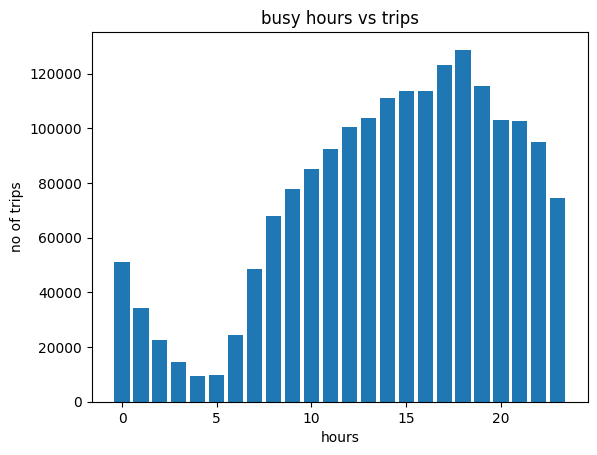

In [57]:
# Visualis the number of trips per hour and find the busiest hour
no_trips = df['pickup_hour'].value_counts()
no_trips = no_trips.sort_values().sort_index()
plt.figure()
plt.bar(no_trips.index, no_trips.values)
plt.ylabel('no of trips')
plt.xlabel('hours')
plt.title('busy hours vs trips')
plt.show()

Find the actual number of trips in the five busiest hours

In [58]:
# Scaling up the number of trips
fraction = 0.05
# Fill in the value of your sampling fraction and use that to scale up the numbers
trips_per_hour = df['pickup_hour'].value_counts()
top_5 = trips_per_hour.sort_values(ascending=False).head(5)
top_5
actual_top_5 = top_5 / fraction
actual_top_5
df['week_day_name'].value_counts()

week_day_name
Thursday     285961
Wednesday    280249
Friday       270279
Saturday     264827
Tuesday      264607
Sunday       229297
Monday       227759
Name: count, dtype: int64

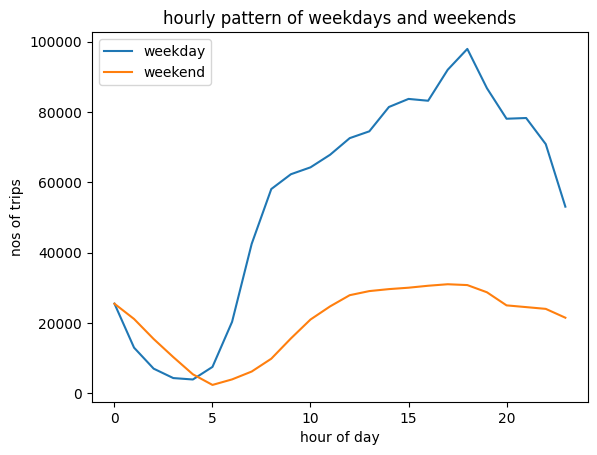

In [59]:
# Comparing traffic trends for the week days and weekends
weekday = ['Thursday', 'Wednesday', 'Friday', 'Tuesday', 'Monday']
weekend = ['Saturday', 'Sunday']
weekend_df = df[df['week_day_name'].isin(weekend)]
weekday_df = df[df['week_day_name'].isin(weekday)]
weekend_trips = weekend_df['pickup_hour'].value_counts()
weekend_trips = weekend_trips.sort_index()
weekday_trips = weekday_df['pickup_hour'].value_counts()
weekday_trips = weekday_trips.sort_index()
plt.plot(weekday_trips.index, weekday_trips.values, label='weekday')
plt.plot(weekend_trips.index, weekend_trips.values, label='weekend')
plt.xlabel('hour of day')
plt.ylabel('nos of trips')
plt.title('hourly pattern of weekdays and weekends')
plt.legend()
plt.show()

In [60]:
# Find top 10 pickup and dropoff zones
top_pickup = df['PULocationID'].value_counts().head(10)
top_drop = df['DOLocationID'].value_counts().head(10)
print(f'\ntop pick up\n{top_pickup}')
print(f'\ntop drop off\n{top_drop}')


top pick up
PULocationID
132    96468
237    86706
161    85684
236    77319
162    65450
138    64054
186    63228
230    61093
142    60683
170    54296
Name: count, dtype: int64

top drop off
DOLocationID
236    81077
237    77379
161    71436
230    56225
170    54152
162    52095
142    51354
239    51132
141    48322
68     46178
Name: count, dtype: int64


In [61]:
# Finding the top 10 and bottom 10 pickup/dropoff ratios
top_pickup = df_clean['PULocationID'].value_counts()
top_drop = df_clean['DOLocationID'].value_counts()
pick_drop = top_pickup.to_frame(name='pickup')
pick_drop['drop'] = top_drop
pick_drop = pick_drop.fillna(0)
pick_drop = pick_drop.drop(pick_drop[pick_drop['drop'] == 0].index)
pick_drop['ratio'] = pick_drop['pickup'] / pick_drop['drop']
top_10_ratio = pick_drop.sort_values(by ='ratio', ascending=False).head(10)
bottom_10_ratio = pick_drop.sort_values(by='ratio', ascending=True).head(10)
print(f"\ntop 10 pickup/drop up ration are \n{top_10_ratio}")
print(f'\nbottom 10 pickup/drop ratio are\n{bottom_10_ratio}')


top 10 pickup/drop up ration are 
              pickup     drop     ratio
PULocationID                           
70              8193    868.0  9.438940
132            94933  19327.0  4.911937
138            63682  21786.0  2.923070
186            62990  39758.0  1.584335
114            23980  17427.0  1.376026
43             30603  22241.0  1.375972
249            40206  30270.0  1.328246
162            65211  51854.0  1.257589
161            85401  71152.0  1.200261
100            29935  25110.0  1.192155

bottom 10 pickup/drop ratio are
              pickup    drop     ratio
PULocationID                          
1                 47  5158.0  0.009112
27                 1    38.0  0.026316
257               21   749.0  0.028037
251                1    31.0  0.032258
198               39   976.0  0.039959
156                1    25.0  0.040000
112              174  3927.0  0.044309
265              317  7083.0  0.044755
115                1    22.0  0.045455
37                83  1

In [62]:
# During night hours (11pm to 5am) find the top 10 pickup and dropoff zones
night_df = df[(df['pickup_hour'] >= 23) | (df['pickup_hour'] <=5)]
top_pick_night_df = night_df['PULocationID'].value_counts().head(10)
print(f"\ntop pickup loaction are\n{top_pick_night_df}")
top_drop_night_df = night_df['DOLocationID'].value_counts().head(10)
print(f'\ntop 10 drop location are\n{top_drop_night_df}')


top pickup loaction are
PULocationID
79     15497
132    14508
249    12441
48     10430
148     9604
114     8732
230     8178
186     6941
164     6127
68      6014
Name: count, dtype: int64

top 10 drop location are
DOLocationID
79     8292
48     6861
170    6251
68     5823
107    5733
141    5257
263    4966
249    4934
230    4622
229    4369
Name: count, dtype: int64


In [63]:
# Filter for night hours (11 PM to 5 AM)
night_df = df_clean[(df_clean['pickup_hour'] >= 23) | (df_clean['pickup_hour'] <=5)]
night_rev = night_df['total_amount'].sum()
day_df = df_clean.drop(night_df.index)
day_rev = day_df['total_amount'].sum()
total_share = day_rev + night_rev
night_share = round((night_rev / total_share) * 100, 2)
day_share = round((day_rev / total_share) * 100, 2)
print(f'night share is {night_share}')
print(f'day share is {day_share}')

night share is 11.97
day share is 88.03


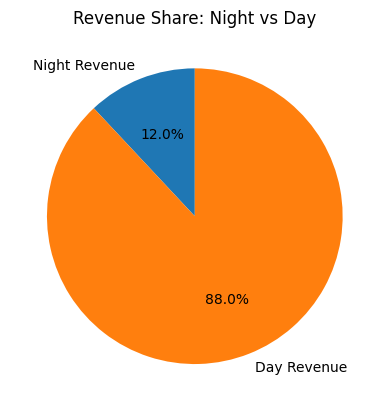

In [64]:
labels = ['Night Revenue', 'Day Revenue']
sizes = [night_share, day_share]
plt.figure()
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Revenue Share: Night vs Day')
plt.show()

##### Pricing Strategy

In [65]:
# Analyse the fare per mile per passenger for different passenger counts
df_clean['fair_distance'] = df_clean['fare_amount'] / df_clean['trip_distance']
df_clean['fair_distance_passenger'] = df_clean['fair_distance'] / df_clean['passenger_count']
pass_df = df_clean.groupby('passenger_count')['fair_distance_passenger'].mean()
pass_df

passenger_count
1.0    10.865142
2.0     6.432423
3.0     3.908099
4.0     4.363292
5.0     1.709614
6.0     1.350744
Name: fair_distance_passenger, dtype: float64

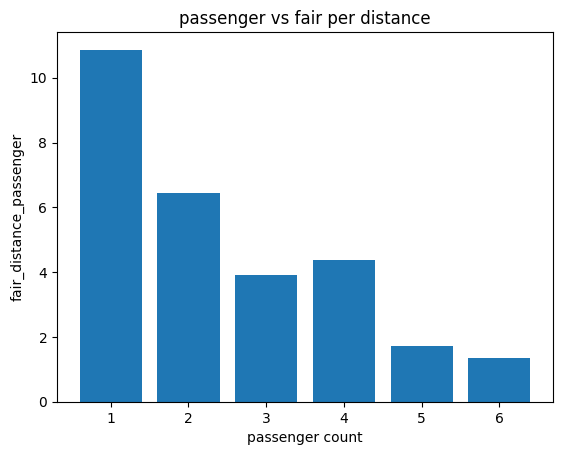

In [66]:
plt.figure()
plt.bar(pass_df.index, pass_df.values)
plt.xlabel('passenger count')
plt.ylabel('fair_distance_passenger')
plt.title('passenger vs fair per distance')
plt.show()

In [67]:
# Comparing the average fare per mile for different days and for different times of the day
def get_time_quarter(hour):
    if hour <= 5:
        return 'Night'
    elif hour <= 11:
        return 'Morning'
    elif hour <= 17:
        return 'Afternoon'
    else:
        return 'Evening'
df_clean['time_quarter'] = df_clean['pickup_hour'].apply(get_time_quarter)

fare_mile_hours = df_clean.groupby(['week_day_name', 'time_quarter'])['fair_distance'].mean().unstack()
fare_mile_hours

time_quarter,Afternoon,Evening,Morning,Night
week_day_name,,,,
Friday,12.112226,10.145505,10.429116,10.143152
Monday,12.116603,10.163979,10.179678,11.756342
Saturday,11.994926,10.571568,10.214654,9.964379
Sunday,13.183444,13.193594,11.513660,11.161977
Thursday,12.972582,9.912372,10.820386,10.914571
Tuesday,12.139654,10.512501,11.042261,14.954089
Wednesday,12.018680,10.430021,10.354558,13.772751


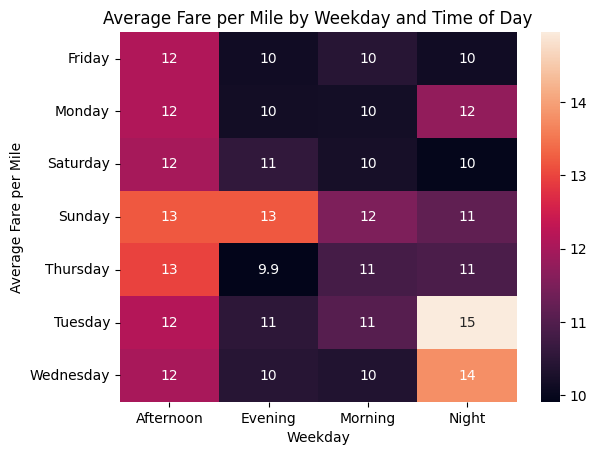

In [68]:
sns.heatmap(data=fare_mile_hours, annot=True)
plt.xlabel('Weekday')
plt.ylabel('Average Fare per Mile')
plt.title('Average Fare per Mile by Weekday and Time of Day')
plt.show()

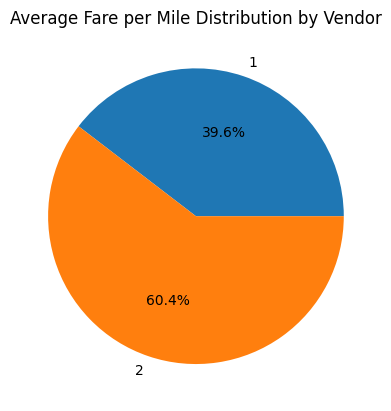

In [69]:
# Comparing fare per mile for different vendors
fare_mile = df_clean.groupby('VendorID')['fair_distance'].mean()
fare_mile
plt.figure()
plt.pie(fare_mile.values, labels=fare_mile.index, autopct='%1.1f%%')
plt.title('Average Fare per Mile Distribution by Vendor')
plt.show()

In [70]:
# Defining distance tiers
def distance_tier(dist):
    if dist <= 2:
        return 'Up to 2 miles'
    elif dist <= 5:
        return '2 to 5 miles'
    else:
        return 'More than 5 miles'

df_clean['distance_tier'] = df_clean['trip_distance'].apply(distance_tier)
vendor_distance = (df_clean.groupby(['VendorID', 'distance_tier'])['fair_distance'].mean().unstack())
vendor_distance

distance_tier,2 to 5 miles,More than 5 miles,Up to 2 miles
VendorID,,,
1,6.381262,4.425174,9.929365
2,6.549258,4.502908,17.929401


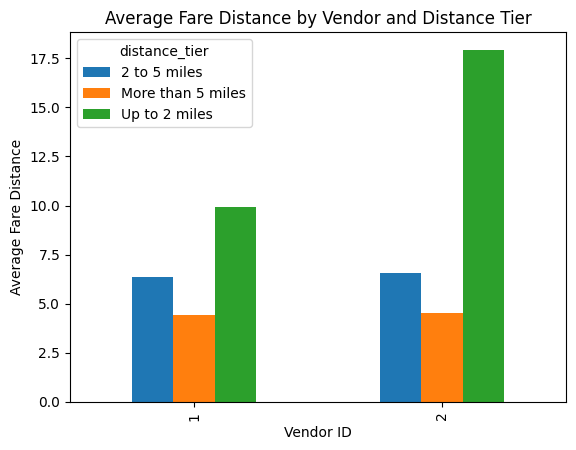

In [71]:
vendor_distance.plot(kind='bar')
plt.xlabel('Vendor ID')
plt.ylabel('Average Fare Distance')
plt.title('Average Fare Distance by Vendor and Distance Tier')
plt.show()

##### Customer Experience and Other Factors

In [72]:
#  Analyzing tip percentages based on distances, passenger counts and pickup times
df_clean['tip_percent'] = (df_clean['tip_amount'] / df_clean['fare_amount'])*100

tip_by_distance = df_clean.groupby('distance_tier')['tip_percent'].mean().reset_index()
print("Average tip percentage by distance:")
print(tip_by_distance)

tip_by_passenger = df_clean.groupby('passenger_count')['tip_percent'].mean().reset_index()
print("\nAverage tip percentage by passenger count:")
print(tip_by_passenger)

tip_by_hour = df_clean.groupby('pickup_hour')['tip_percent'].mean().reset_index()
print("\nAverage tip percentage by pickup hour:")
print(tip_by_hour)

Average tip percentage by distance:
       distance_tier  tip_percent
0       2 to 5 miles    18.766539
1  More than 5 miles    17.641621
2      Up to 2 miles    22.419050

Average tip percentage by passenger count:
   passenger_count  tip_percent
0              1.0    20.937303
1              2.0    19.731129
2              3.0    19.027261
3              4.0    17.456009
4              5.0    20.490034
5              6.0    20.602040

Average tip percentage by pickup hour:
    pickup_hour  tip_percent
0             0    20.502825
1             1    20.663966
2             2    20.651999
3             3    20.512864
4             4    18.250806
5             5    17.485191
6             6    18.466711
7             7    19.606031
8             8    20.047148
9             9    19.707017
10           10    19.242829
11           11    19.195368
12           12    19.134485
13           13    19.059848
14           14    19.031695
15           15    19.011939
16           16    20.91601

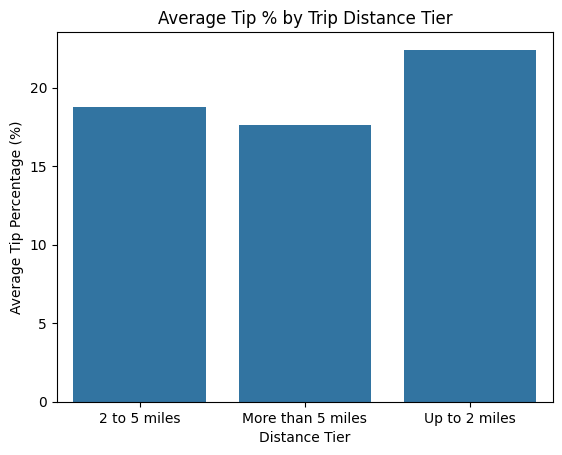

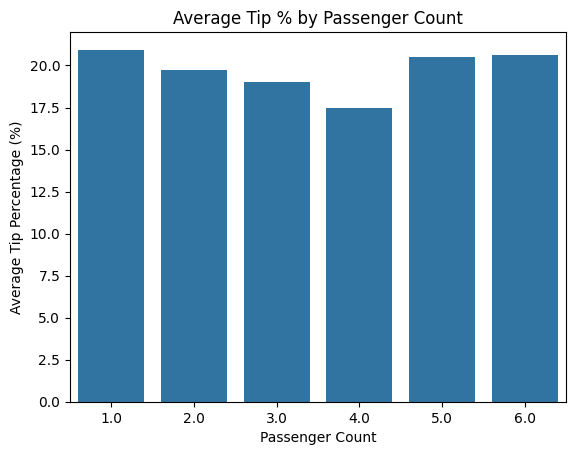

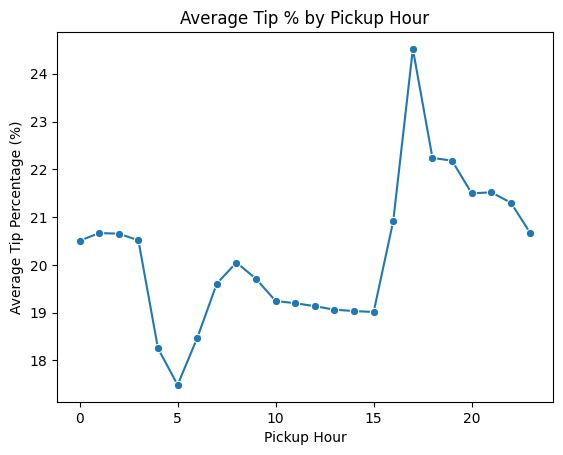

In [73]:
plt.figure()
sns.barplot(data = tip_by_distance, x= 'distance_tier',  y= 'tip_percent')
plt.xlabel('Distance Tier')
plt.ylabel('Average Tip Percentage (%)')
plt.title('Average Tip % by Trip Distance Tier')
plt.show()

plt.figure()
sns.barplot(data = tip_by_passenger, x= 'passenger_count',  y= 'tip_percent')
plt.xlabel('Passenger Count')
plt.ylabel('Average Tip Percentage (%)')
plt.title('Average Tip % by Passenger Count')
plt.show()

plt.figure()
sns.lineplot(data=tip_by_hour, x='pickup_hour', y='tip_percent', marker='o')
plt.xlabel('Pickup Hour')
plt.ylabel('Average Tip Percentage (%)')
plt.title('Average Tip % by Pickup Hour')
plt.show()


In [74]:
# Comparing trips with tip percentage < 10% to trips with tip percentage > 25%
df_10  = df_clean[df_clean['tip_percent'] <= 10]
df_25 = df_clean[df_clean['tip_percent'] >= 25]
x = df_10.groupby('distance_tier')['tip_percent'].mean()
print(f'10 % tip vs distance{x}\n')
y = df_25.groupby('distance_tier')['tip_percent'].mean()
print(f'25 % tip vs distance{y}')

10 % tip vs distancedistance_tier
2 to 5 miles         1.622269
More than 5 miles    1.278886
Up to 2 miles        0.923215
Name: tip_percent, dtype: float64

25 % tip vs distancedistance_tier
2 to 5 miles         29.060867
More than 5 miles    34.850419
Up to 2 miles        33.260405
Name: tip_percent, dtype: float64


<Figure size 640x480 with 0 Axes>

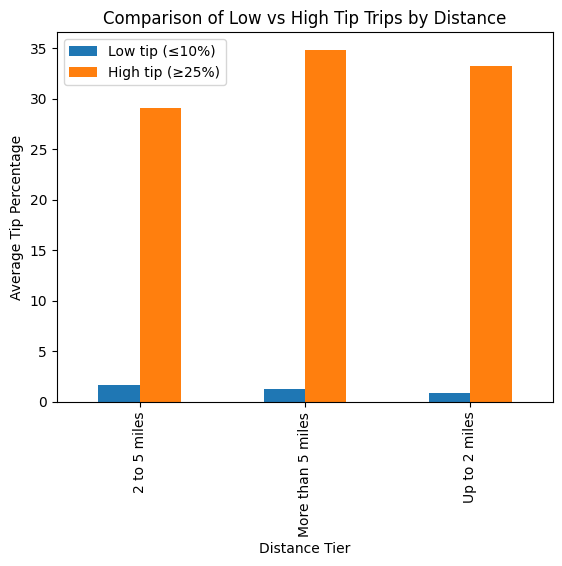

In [75]:
#Graph to visualize
compare_df = pd.DataFrame({'Low tip (≤10%)': x, 'High tip (≥25%)': y})
plt.figure()
compare_df.plot(kind='bar')
plt.xlabel('Distance Tier')
plt.ylabel('Average Tip Percentage')
plt.title('Comparison of Low vs High Tip Trips by Distance')
plt.show()

In [76]:
# Passenger count varies across hours and days
x = df_clean.groupby(['week_day_name', 'pickup_hour'])['passenger_count'].sum()
x_df = x.unstack()
print(x_df.head(5))

pickup_hour         0        1        2       3       4       5       6   \
week_day_name                                                              
Friday         10923.0   6224.0   3595.0  2112.0  1429.0  2007.0  4668.0   
Monday          5195.0   2729.0   1396.0  1036.0  1026.0  1832.0  4820.0   
Saturday       18190.0  14833.0  10995.0  6964.0  3376.0  1399.0  2616.0   
Sunday         19255.0  15993.0  11544.0  7893.0  4182.0  1749.0  2544.0   
Thursday        7574.0   3743.0   2003.0  1225.0  1096.0  1917.0  5283.0   

pickup_hour         7        8        9   ...       14       15       16  \
week_day_name                             ...                              
Friday          9428.0  12861.0  14710.0  ...  22209.0  23387.0  22877.0   
Monday          9625.0  13166.0  14358.0  ...  20214.0  21284.0  20938.0   
Saturday        4190.0   7150.0  11386.0  ...  22149.0  23384.0  24144.0   
Sunday          3983.0   6254.0  10471.0  ...  21447.0  21021.0  21239.0   
Thursday   

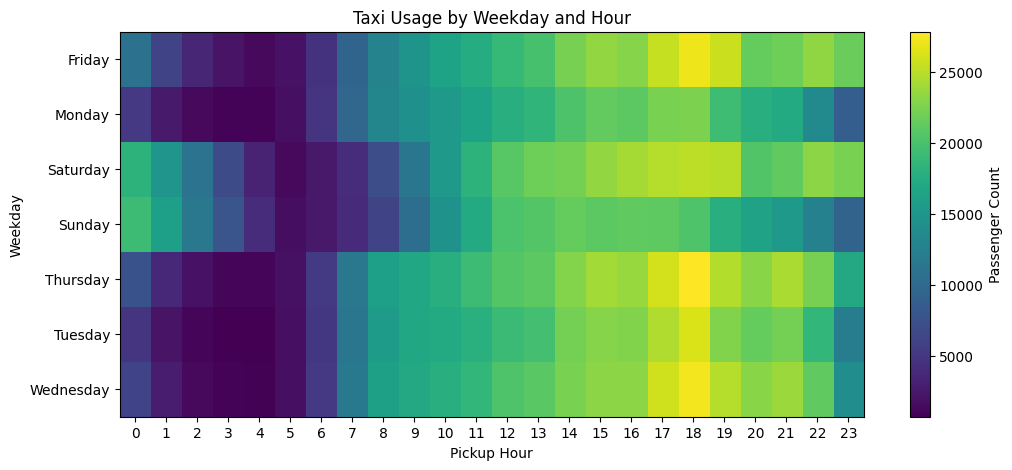

In [77]:
plt.figure(figsize=(12, 5))
plt.imshow(x_df, aspect='auto')

plt.colorbar(label='Passenger Count')

plt.xticks(range(len(x_df.columns)), x_df.columns)
plt.yticks(range(len(x_df.index)), x_df.index)

plt.xlabel('Pickup Hour')
plt.ylabel('Weekday')
plt.title('Taxi Usage by Weekday and Hour')

plt.show()

In [78]:
# Passenger count varying across zones
avg_zone_pass = df_clean.groupby('PULocationID')['passenger_count'].mean().reset_index()
avg_zone_pass

,PULocationID,passenger_count
0,1,1.319149
1,2,1.000000
2,3,1.000000
3,4,1.436053
4,5,1.000000
...,...,...
250,261,1.544986
251,262,1.329785
252,263,1.337978
253,264,1.347199


In [79]:
# Creating a new column for the average passenger count in each zone.
zones_with_trips = zones.merge(avg_zone_pass, left_on='LocationID', right_on='PULocationID', how='left')
zones_with_trips

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,PULocationID,passenger_count
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19...",1.0,1.319149
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343...",2.0,1.000000
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.77 256767.698, 1026495.593 2...",3.0,1.000000
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20...",4.0,1.436053
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.31 144283.336, 936046.565 144...",5.0,1.000000
...,...,...,...,...,...,...,...,...,...
258,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx,"POLYGON ((1025414.782 270986.139, 1025138.624 ...",259.0,1.057143
259,260,0.133514,0.000422,Woodside,260,Queens,"POLYGON ((1011466.966 216463.005, 1011545.889 ...",260.0,1.321192
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,"POLYGON ((980555.204 196138.486, 980570.792 19...",261.0,1.544986
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,"MULTIPOLYGON (((999804.795 224498.527, 999824....",262.0,1.329785


<bound method Series.info of PULocationID
2      100.00
59     100.00
187    100.00
229     99.79
237     99.79
        ...  
251      0.00
254      0.00
253      0.00
258      0.00
259      0.00
Name: surcharge, Length: 255, dtype: float64>
pickup surcharge loction PULocationID
2      100.00
59     100.00
187    100.00
229     99.79
237     99.79
141     99.75
12      99.75
249     99.73
262     99.72
114     99.69
Name: surcharge, dtype: float64
dropoff surcharge loction DOLocationID
114    99.87
249    99.86
237    99.86
144    99.86
229    99.86
113    99.85
158    99.84
211    99.83
224    99.83
246    99.83
Name: surcharge, dtype: float64


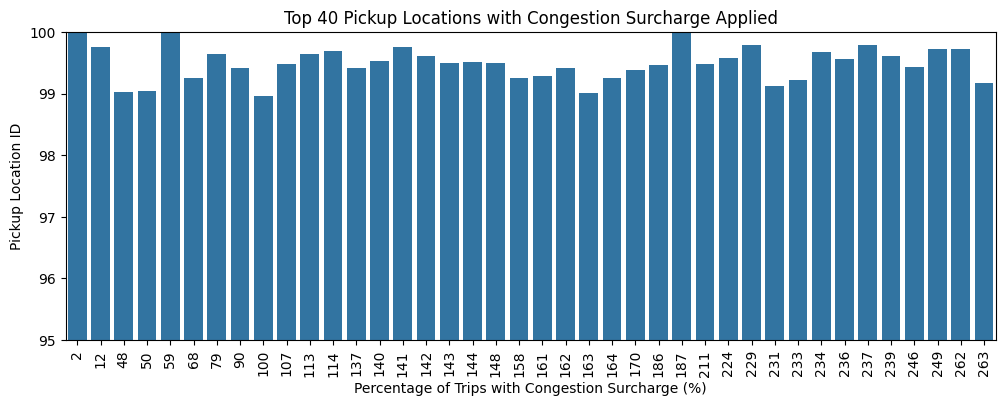

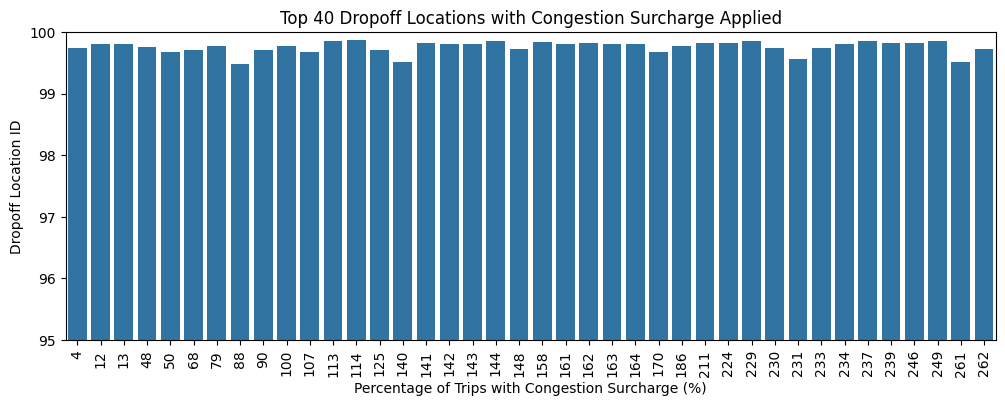

In [80]:
# How often is each surcharge applied?
df_clean['surcharge'] = (df_clean['congestion_surcharge'] > 0).astype(int)
pickup_surcharge = round((df_clean.groupby('PULocationID')['surcharge'].mean() * 100), 2).sort_values(ascending=False)
print(pickup_surcharge.info)
drop_surcharge = round((df_clean.groupby('DOLocationID')['surcharge'].mean() * 100), 2).sort_values(ascending=False)
print(f'pickup surcharge loction {pickup_surcharge.head(10)}')
print(f'dropoff surcharge loction {drop_surcharge.head(10)}')

top_pickup = pickup_surcharge.head(40)

plt.figure(figsize=(12,4))
sns.barplot(x=top_pickup.index, y=top_pickup.values)
plt.xlabel('Percentage of Trips with Congestion Surcharge (%)')
plt.xticks(rotation= 90)
plt.ylim(95, 100)
plt.ylabel('Pickup Location ID')
plt.title('Top 40 Pickup Locations with Congestion Surcharge Applied')
plt.show()

top_dropoff = drop_surcharge.head(40)

plt.figure(figsize=(12,4))
sns.barplot(x=top_dropoff.index, y=top_dropoff.values)
plt.ylim(95, 100)
plt.xticks(rotation= 90)
plt.xlabel('Percentage of Trips with Congestion Surcharge (%)')
plt.ylabel('Dropoff Location ID')
plt.title('Top 40 Dropoff Locations with Congestion Surcharge Applied')
plt.show()


## Conclusion

In [95]:
top_routes = (df_clean.groupby('time_quarter')['PULocationID'].value_counts().groupby(level=0).head(5))
print(top_routes.reset_index())

   time_quarter  PULocationID  count
0     Afternoon           237  37770
1     Afternoon           161  35999
2     Afternoon           236  35043
3     Afternoon           132  33202
4     Afternoon           138  25434
5       Evening           132  36900
6       Evening           161  32117
7       Evening           237  26594
8       Evening           142  24582
9       Evening           230  23431
10      Morning           236  22667
11      Morning           237  20389
12      Morning           186  18578
13      Morning           132  16589
14      Morning           162  15298
15        Night            79  11872
16        Night           249   8962
17        Night           132   8242
18        Night           148   7877
19        Night            48   7331


###  The results show that certain routes, based on pickup locations, are used more frequently during specific times of the day.
### By pre-positioning taxis at high-demand pickup locations along these routes during the corresponding time periods, passenger wait times can be reduced and dispatch efficiency can be improved.

In [92]:
# Suggestions on strategically positioning cabs across different zones to make best use of insights uncovered by
# analysing trip trends across time, days and months.
top_routes_by_time = (df_clean.groupby(['months', 'week_day_name', 'pickup_hour'])['PULocationID'].value_counts().groupby(level=[0, 1, 2]).head(3))
print(top_routes_by_time.reset_index())

         months week_day_name  pickup_hour  PULocationID  count
0         April        Friday            0            79     46
1         April        Friday            0           249     41
2         April        Friday            0           132     38
3         April        Friday            1           249     38
4         April        Friday            1           132     37
...         ...           ...          ...           ...    ...
6043  September     Wednesday           22           132     65
6044  September     Wednesday           22           230     63
6045  September     Wednesday           23           132     60
6046  September     Wednesday           23           138     47
6047  September     Wednesday           23           161     41

[6048 rows x 5 columns]


### By positioning cabs in high-demand pickup zones identified for specific hours, days, and months, operators can reduce idle time, minimize passenger wait times, and improve overall fleet utilization.

In [94]:
# Propose data-driven adjustments to the pricing strategy to maximize revenue while maintaining competitive rates
# with other vendors.
zone_demand = df.groupby('PULocationID').size().sort_values(ascending=False)
zone_fare = df.groupby('PULocationID')['fare_amount'].mean()
zone_pricing_signal = pd.DataFrame({'trip_count': zone_demand, 'avg_fare': zone_fare})
zone_pricing_signal.head(25)

,trip_count,avg_fare
PULocationID,,
1,199,91.813467
2,2,70.000000
3,34,32.470588
4,1843,16.402892
5,10,62.800000
6,24,13.533333
7,812,18.199138
8,6,37.475000
9,24,29.866667


### Zones with higher trip volumes and higher average fares indicate strong demand and pricing power, and can be prioritized for slight fare premiums, while low-demand zones can use competitive pricing to maintain ridership.